In [2]:

import numpy as np
import pandas as pd

from bs4 import BeautifulSoup
import re

import os

# initialize lists
lst_pos     = []
lst_title   = []
lst_artist  = []
lst_dt      = []
lst_avg     = []
lst_rtgs    = []
lst_rvws    = []
lst_gnrs    = []
lst_sbgnrs  = []
lst_dcrptrs = []

# iterate through every saved page
for fname in os.listdir('pages'):

    # read page, parse html
    with open(f'pages/{fname}', 'r', encoding='utf-8') as f:
        parsed_html = BeautifulSoup( f.read() )
        f.close()

    # loop through every release on the page
    for rls in parsed_html.findAll("div", {"class": "topcharts_itembox chart_item_release"}):

        # title, artist, etc.
        pos    = rls.findAll("div", {"class": "topcharts_position"})[0].text.strip()
        title  = rls.findAll("a",   {"class": "release"})[0].text.strip()
        artist = rls.findAll("a",   {"class": "artist"})[0].text.strip()
        dt     = rls.findAll("div", {"class": "topcharts_item_releasedate"})[0].text.strip()

        # ratings
        avg    = rls.findAll("span", {"class": "topcharts_stat topcharts_avg_rating_stat"})[0].text.strip()
        rtgs   = rls.findAll("span", {"class": "topcharts_stat topcharts_ratings_stat"})[0].text.strip()

        # convert numbers
        pos  = int( re.sub(r"\W+", "", pos) )
        avg  = int( re.sub(r"\W+", "", avg) )
        rtgs = int( re.sub(r"\W+", "", rtgs) )

        # genres, descriptors
        genres      = rls.findAll("a", {"class": "genre topcharts_item_genres"})
        subgenres   = rls.findAll("a", {"class": "genre topcharts_item_secondarygenres"})
        descriptors = rls.findAll("span", {"class": "topcharts_item_descriptors"})
        
        # extract text from elements
        genres = [ re.sub(r"\W+", "", i.text.strip()).lower() for i in genres]
        subgenres = [ re.sub(r"\W+", "", i.text.strip()).lower() for i in subgenres]
        descriptors = [ re.sub(r"\W+", "", i.text.strip()).lower() for i in descriptors]

        # concatenate lists
        genres = '|'.join(genres)
        subgenres = '|'.join(subgenres)
        descriptors = '|'.join(descriptors)

        # append to the list
        lst_pos.append( pos )
        lst_title.append( title )
        lst_artist.append( artist )
        lst_dt.append( dt )
        lst_avg.append( avg )
        lst_rtgs.append( rtgs )
        lst_gnrs.append( genres )
        lst_sbgnrs.append( subgenres )
        lst_dcrptrs.append( descriptors )

# make dataframe
df = pd.DataFrame({
    'pos':          lst_pos,
    'title':        lst_title,
    'artist':       lst_artist,
    'date':         lst_dt,
    'average':      lst_avg,
    'ratings':      lst_rtgs,
    'genres':       lst_gnrs,
    'subgenres':    lst_sbgnrs,
    'descriptors':  lst_dcrptrs,
}).drop_duplicates().sort_values(['pos'])

# save dataframe
df.to_csv('albumsParsed.csv')
print(df.shape)

df.head()

(1000, 9)


,pos,title,artist,date,average,ratings,genres,subgenres,descriptors
0,1,OK Computer,Radiohead,16 June 1997,423,62869,alternativerock|artrock,,melancholic|anxious|futuristic|alienation|exis...
1,2,In the Court of the Crimson King,King Crimson,10 October 1969,430,39657,progressiverock|artrock,symphonicprog|jazzrock|freeimprovisation|psych...,fantasy|epic|progressive|philosophical|complex...
2,3,Wish You Were Here,Pink Floyd,12 September 1975,429,43378,progressiverock|artrock,psychedelicrock,melancholic|atmospheric|progressive|malevocals...
3,4,Kid A,Radiohead,3 October 2000,421,52285,artrock|experimentalrock|electronic,ambient|electronic|idm,cold|melancholic|futuristic|atmospheric|anxiou...
4,5,Loveless,My Bloody Valentine,4 November 1991,424,42910,shoegaze|noisepop,dreampop,noisy|romantic|ethereal|atmospheric|wallofsoun...


In [3]:
# create sparse matrix, bag-of-words style

words = set()

# genres
for g in df.loc[:, 'genres']:
    for w in g.split('|'):

        if w not in words:
            words.add(f"g:{w}")

# subgenres
for s in df.loc[:, 'subgenres']:
    for w in s.split('|'):

        if w not in words:
            words.add(f"s:{w}")

# descriptors
for d in df.loc[:, 'descriptors']:
    for w in d.split('|'):

        if w not in words:
            words.add(f"d:{w}")

words = {v: i for i, v in enumerate(words)}

# initialize sparse matrix
sparse = np.zeros(
    shape=(len(df), len(words))
)

# populate sparse matrix
for i, idx in enumerate(df.index):

    for w in df.loc[idx, 'genres'].split('|'):
        j = words[f"g:{w}"]
        sparse[i][j] = 1

    for w in df.loc[idx, 'subgenres'].split('|'):
        j = words[f"s:{w}"]
        sparse[i][j] = 1

    for w in df.loc[idx, 'descriptors'].split('|'):
        j = words[f"d:{w}"]
        sparse[i][j] = 1

sparse = pd.DataFrame(sparse, columns=words.keys())

sparse_cols = []
for c in sparse.columns:
    df.loc[:, f'sparse:{c}'] = sparse.loc[:, c]
    sparse_cols.append(f'sparse:{c}')

sparse

,s:celticnewage,g:protopunk,g:pianorock,s:cabaret,g:idm,d:suite,d:improvisation,g:hardcorehiphop,g:jazzfusion,d:complex,...,s:shibuyakei,s:frenchpop,g:chambermusic,s:shoegaze,s:minimalsynth,d:aggressive,s:guajira,g:rootsrock,g:hardbop,d:repetitive
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
from sklearn.decomposition import NMF

model = NMF(n_components=200, init='random', random_state=0)
W = model.fit_transform(sparse)

mf = pd.DataFrame(W)

mf_cols = []
for c in mf.columns:
    df.loc[:, f'mf:{c}'] = mf.loc[:, c]
    mf_cols.append(f'mf:{c}')

mf

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.511758,0.0,0.000000,0.0,0.000000,0.0,0.0,0.542791,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
1,0.506957,0.0,0.000000,0.0,0.004166,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
2,0.511743,0.0,0.000000,0.0,0.000000,0.0,0.0,0.543253,0.000000,0.00000,...,0.0,0.0,0.000000,0.222708,0.00000,0.0,0.0,0.0,0.000000,0.000000
3,0.512909,0.0,0.000000,0.0,0.000000,0.0,0.0,0.542366,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
4,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.543192,0.000000,0.00000,...,0.0,0.0,0.002864,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.272154,0.0,0.000141,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.000000,0.000000,0.00472,0.0,0.0,0.0,0.004798,0.000000
996,0.509409,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00645,...,0.0,0.0,0.000000,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.000000
997,0.000000,0.0,0.883126,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.00000,...,0.0,0.0,0.240076,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.091777
998,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.752111,0.00000,...,0.0,0.0,0.000000,0.223832,0.00000,0.0,0.0,0.0,0.000000,0.000000


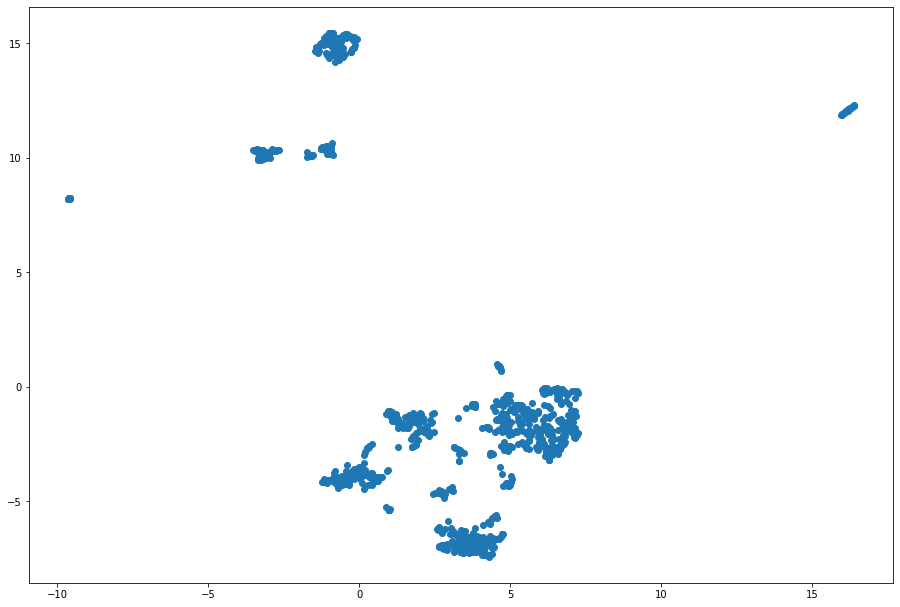

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

from umap import UMAP

fit = UMAP()

embedding = fit.fit_transform(mf)
embedding = pd.DataFrame(embedding)

embedding.head()

fig = plt.figure()
ax = fig.add_axes([0,0,2,2,])

ax.scatter(
    embedding.loc[:, 0],
    embedding.loc[:, 1],
)

plt.show()

umap_cols = []
for c in embedding.columns:
    df.loc[:, f'umap:{c}'] = embedding.loc[:, c]
    umap_cols.append(f'umap:{c}')


In [24]:
# cosine similarity
from scipy import spatial

def recommend(df, title, cols=embedding.columns):

    cols = [c for c in cols if c not in {'cluster'}]
    target_data = df.loc[df.loc[:,'title']==title,cols].to_numpy()[0]
    df.loc[:,'index'] = df.apply(lambda x: spatial.distance.euclidean( target_data, np.array(x[cols], dtype=np.float32) ), axis=1)
        
    return df

rec = recommend(
    df=df, 
    title='In Rainbows', 
    cols=umap_cols
)

rec.sort_values(['index']).loc[:,['title','index','genres']].head(30)

,title,index,genres
15,In Rainbows,0.000000,artrock|alternativerock
339,Requiem,0.078120,classicalperiod|choral|christianliturgicalmusi...
243,Sorrow Tears and Blood,0.082516,afrobeat
396,This Heat,0.085462,experimentalrock|experimental
586,Morbid Tales,0.093000,thrashmetal
0,OK Computer,0.107066,alternativerock|artrock
798,Who's Next,0.109434,hardrock
128,Slanted and Enchanted,0.113552,lofislackerrock|indierock|noisepop
357,I'm Still in Love With You,0.130348,southernsoul
3,Kid A,0.137732,artrock|experimentalrock|electronic
